In [144]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from collections import defaultdict

In [145]:
def read_data():
    data = list()
    filename = 'train.dat'
    f = open(filename, 'r')
    for document in f:
        data.append(document.rstrip())
    return data

    
def preprocess(data):    
    remove_space = list()
    for doc in data:
        remove_space.append(doc.split(" "))

    term = list()
    frequency = list()

    for doc in remove_space:
        l1 = list()
        l2 = list()
        for i in range(0, len(doc), 2):
            l1.append(doc[i])
        for i in range(1, len(doc), 2):
            l2.append(doc[i])
        term.append(l1)
        frequency.append(l2)
        
    return term, frequency


In [146]:
def build_dict(terms):
    num_rows = len(terms)
    dict_words = {}
    tid = 0
    nnz = 0
    num_cols = 0
    for t in terms:
        nnz += len(t)
        for w in t:
            if w not in dict_words:
                dict_words[w] = tid
                tid += 1
                
    num_cols = len(dict_words)
    return num_rows, num_cols, nnz
    
def build_csr(term, frequency, nnz, num_rows, num_cols):
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.int)
    ptr = np.zeros(num_rows+1, dtype=np.int)
    n = 0
    i = 0
    for (index, value) in zip(term, frequency):
        l = len(index)
        for j in range(l):
            ind[n + j] = index[j]
            val[n + j] = value[j]
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
    print 
    mat = csr_matrix((val, ind, ptr), shape=(num_rows, max(ind)+1), dtype=np.int)
    mat.sort_indices()
    
    return mat

In [147]:

def cluster_indexing(mat, centroids):
    
    index = list()
    similarity_mat = mat.dot(centroids.T)   
    for i in range(similarity_mat.shape[0]):
        row = similarity_mat[i]
        top_index = row.argmax(axis = 0).any()
        index.append(top_index + 1)
    return index

def calculate_centroids(mat, idx, k):    
    centroids = list()
    for i in range(1,k+1):
        indi = [j for j, x in enumerate(idx) if x == i]        
        items = mat[indi,:]
        if (items.shape[0] > 1):
            centroids.append(np.mean(items, axis=0))            
    centroids = np.array(centroids)
    return centroids

In [148]:
from sklearn.utils import shuffle
def kmeans(k, mat, n_iter):
    centroids = shuffle(mat, n_samples=k)
    for i in range(n_iter):
        index = cluster_indexing(mat, centroids)
        centroids = calculate_centroids(mat, index, k)
    return index

In [149]:
def calculateSSE(cluster, mat, k):
    sse = 0
    ret = 0
    for i in range(1,k+1):
        indi = [j for j, x in enumerate(cluster) if x == i]       
        items = mat[indi,:]
        if (items.shape[0] > 1):
            mean = np.mean(items, axis=0)
            sse = items - mean
            sse_sq = np.square(sse)
            ret += sse_sq.sum()
    return ret

In [150]:
import sys
def next_cluster(cluster, k):
    max_count = 0
    for i in range(1,k+1):
        index = [j for j, x in enumerate(cluster) if x == i]
        sum_index = len(index)
        if(max_count < sum_index):
            max_count = sum_index
            max_i = i
    return max_i, max_count

In [151]:
import sys
def bisectingKmeans(n_iter, mat, k):
    
    res_cluster = np.ones(mat.shape[0], dtype= np.int)    
    min_sse = sys.maxsize
    orig_mat = mat
    
    for i in range(2, k+1):
        
        print("Bisect... k = %d " % (i))
        min_sse = sys.maxsize
        for j in range(n_iter):
            
            cluster = kmeans(2, mat, 20)
            sse = calculateSSE(cluster, mat, i)
            if sse < min_sse:
                min_sse = sse
                min_cluster = cluster
        
        if(i > 2):
            for j in range(len(min_cluster)):
                if(min_cluster[j] == 1):
                    res_cluster[index[j]] = i
                else:
                    res_cluster[index[j]] = n_cluster_num
        if(i == 2): 
            res_cluster = min_cluster
        n_cluster_num, count = next_cluster(res_cluster, i)
        index = [j for j, x in enumerate(res_cluster) if x == n_cluster_num]
        
        mat = orig_mat[index, :]
    return res_cluster

In [152]:

data = read_data()
terms, frequency = preprocess(data)
num_rows, num_cols, nnz = build_dict(terms)
#print num_rows, num_cols

mat = build_csr(terms, frequency, nnz, num_rows, num_cols)
mat.shape


(8580, 126356)

In [104]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, n_iter=7)
svd.fit(mat)
mat_svd = svd.transform(mat)
#X_test_svd = svd.transform(xTest)

mat_svd.shape

(8580, 1000)

In [163]:
cluster = bisectingKmeans(11, mat_svd, 7)
sse = calculateSSE(cluster, mat_svd, 7)
print sse

Bisect... k = 2 
Bisect... k = 3 
Bisect... k = 4 
Bisect... k = 5 
Bisect... k = 6 
Bisect... k = 7 
4164805.81448


In [125]:
#Writing to a file.
text_file = open("output17.dat", "w")
for i in cluster:
    text_file.write(str(i) +'\n')
text_file.close()

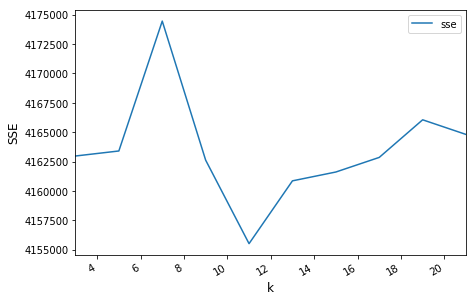

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.__version__
%matplotlib inline


df = pd.read_csv('sample1.csv', header=None)


df[['k', 'sse']] = df[[0, 1]]
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("k",fontsize=12)
ax.set_ylabel("SSE",fontsize=12)
df.plot(kind='line', x='k', y='sse', ax=ax)
#comp.plot("ds", "delta", ax=ax)
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right');